In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

#import lightgbm as lgb
#import xgboost as xgb
import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'claim'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 20000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-sep-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_solution.csv")

# Preprocessing

In [5]:
features = [col for col in train.columns if 'f' in col]

In [6]:
train['n_missing'] = train[features].isna().sum(axis=1)
test['n_missing'] = test[features].isna().sum(axis=1)

features += ['n_missing']

In [7]:
train[features] = train[features].fillna(train[features].median())
test[features] = test[features].fillna(test[features].median())

In [8]:
ss = StandardScaler()


In [9]:
test[features]

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,n_missing
0,0.165850,0.487050,1295.00,0.023100,0.31900,0.901880,573.29,3743.7,2.705700e+12,6221.000000,...,-22.1890,2.0655,0.430880,-10.7410,81606.00,1.1940,1.980400e+14,2017.10,0.46357,1
1,0.129650,0.373480,1763.00,0.728840,0.33247,-1.263100,875.55,554370.0,5.955700e+14,934.430000,...,-1.6342,1.5736,-1.071200,11.8320,90114.00,1.1507,4.388000e+16,6638.90,0.28125,0
2,0.120190,0.445210,736.26,0.046150,0.29605,0.316650,2659.50,317140.0,3.977800e+14,131.810000,...,-32.7800,2.1364,-1.931200,-3.2804,37739.00,1.1548,1.718100e+14,5844.00,0.13797,1
3,0.054008,0.395960,996.14,0.859340,0.36678,-0.170600,386.56,325680.0,-3.432200e+13,-26.473000,...,-2.4162,1.5199,-0.011633,1.3840,26849.00,1.1490,2.138800e+17,6173.30,0.32910,0
4,0.079947,-0.006919,10574.00,0.348450,0.45008,-1.842000,3027.00,428150.0,9.291500e+11,5999.400000,...,-18.6300,3.7387,0.757080,-4.9405,50336.00,1.2488,2.151300e+17,2250.10,0.33796,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493469,-0.009112,0.308190,637.64,0.778200,0.41415,-1.068500,651.22,985000.0,6.079700e+15,508.820000,...,-17.5100,2.3325,0.112260,-5.9238,19429.00,1.1559,8.163900e+16,857.09,1.56330,2
493470,0.088922,0.482650,6924.10,0.025963,0.35540,-0.870200,2514.20,18004.0,6.073500e+14,-0.008665,...,-7.8690,1.7005,97.813000,4.3793,-2432.00,1.0707,4.691800e+16,7497.10,0.67075,0
493471,0.140620,0.484750,1797.10,0.147020,0.28803,-1.407100,434.03,333050.0,2.351000e+15,33492.000000,...,-5.3824,1.6827,1.730400,8.0633,2471.40,1.1725,7.900900e+16,2904.60,0.18005,5
493472,0.168000,0.351760,454.79,0.164580,0.16983,0.323850,2331.20,223980.0,-2.795300e+12,93.561000,...,-4.2416,1.3531,155.210000,13.9630,-11.44,1.1946,-1.770600e+14,6763.10,0.33223,0


In [10]:
train[target]

0         1
1         0
2         1
3         1
4         1
         ..
957914    0
957915    1
957916    0
957917    1
957918    0
Name: claim, Length: 957919, dtype: int64

# CatB

In [11]:
ctb_params = {
     'objective': 'CrossEntropy',
     'n_estimators':N_ESTIMATORS,
     'thread_count' : -1,
     'bootstrap_type': 'Bernoulli',
     'eval_metric': 'AUC',

    'learning_rate': 0.02754358505029776,
    'subsample': 0.4124134017568077, 
    'colsample_bylevel': 0.39790985777442056, 
    'max_depth': 6, 
    'min_child_samples': 36, 
    'max_bin': 345, 
    'reg_lambda': 0.0006816430642472154,
    'random_strength': 40.23678264726923
}

In [12]:
ctb_oof = np.zeros(train.shape[0])
ctb_pred = np.zeros(test.shape[0])
ctb_importances = pd.DataFrame()


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED+9]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")


    X_train = train[features].iloc[trn_idx]
    y_train = train[target].iloc[trn_idx]
    X_valid = train[features].iloc[val_idx]
    y_valid = train[target].iloc[val_idx]
    X_test = test[features]

    X_train[features] = ss.fit_transform(X_train[features])
    X_valid[features] = ss.transform(X_valid[features])
    X_test[features] = ss.transform(X_test[features])

    start = time.time()
    for inseed in seed_list:
        ctb_params['random_state'] = inseed

        pre_model = ctb.CatBoostClassifier(**ctb_params)
        pre_model.fit(
            X_train, 
            y_train,
            eval_set=[(X_valid, y_valid)],
            use_best_model=True,
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            verbose=VERBOSE,
        )

        ctb_params2 = ctb_params.copy()
        ctb_params2['reg_lambda'] *= 0.9
        #ctb_params2['reg_alpha'] *= 0.9
        ctb_params2['learning_rate'] *= 0.1
        model = ctb.CatBoostClassifier(**ctb_params2)
        model.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                use_best_model=True,
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
                init_model=pre_model
        )    

        with open(f"ctb_model{fold}_seed{inseed}.pkl", 'wb') as f:
            pickle.dump(model, f)

        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = X_train.columns
        fi_tmp['importance'] = model.feature_importances_
        fi_tmp['fold'] = fold
        fi_tmp['seed'] = inseed
        ctb_importances = ctb_importances.append(fi_tmp)

        ctb_oof[val_idx] += model.predict_proba(X_valid)[:,-1] / len(seed_list)
        ctb_pred += model.predict_proba(X_test)[:,-1] / len(seed_list)


    elapsed = time.time() - start
    auc = roc_auc_score(y_valid, ctb_oof[val_idx])
    print(f"fold {fold} - ctb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")            

ctb_pred /= N_SPLITS
print(f"oof ctb_auc = {roc_auc_score(train[target], ctb_oof)}")

np.save("ctb_oof.npy", ctb_oof)
np.save("ctb_pred.npy", ctb_pred)

===== fold 0 =====
0:	test: 0.7745247	best: 0.7745247 (0)	total: 272ms	remaining: 1h 30m 48s
1000:	test: 0.8129299	best: 0.8129299 (1000)	total: 3m 28s	remaining: 1h 6m 5s
2000:	test: 0.8143209	best: 0.8143299 (1991)	total: 6m 58s	remaining: 1h 2m 46s
3000:	test: 0.8148229	best: 0.8148276 (2991)	total: 10m 31s	remaining: 59m 36s
4000:	test: 0.8150371	best: 0.8150407 (3997)	total: 14m 4s	remaining: 56m 15s
5000:	test: 0.8153683	best: 0.8153722 (4998)	total: 17m 36s	remaining: 52m 48s
6000:	test: 0.8154548	best: 0.8154824 (5820)	total: 21m 8s	remaining: 49m 19s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.8154861207
bestIteration = 6093

Shrink model to first 6094 iterations.
0:	test: 0.8154861	best: 0.8154861 (0)	total: 200ms	remaining: 1h 6m 30s
1000:	test: 0.8154983	best: 0.8154984 (988)	total: 3m 26s	remaining: 1h 5m 11s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.8155071834
bestIteration = 1334

Shrink model to first 1335 iterations.


# OOF predictions

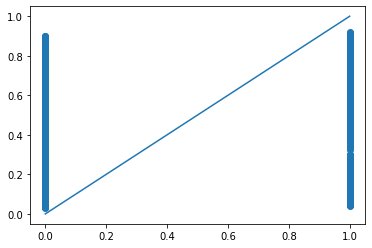

In [13]:
plt.plot(train[target], train[target])
plt.scatter(train[target], ctb_oof)

# Features importances

Text(0.5, 1.0, 'LightGBM feature importances')

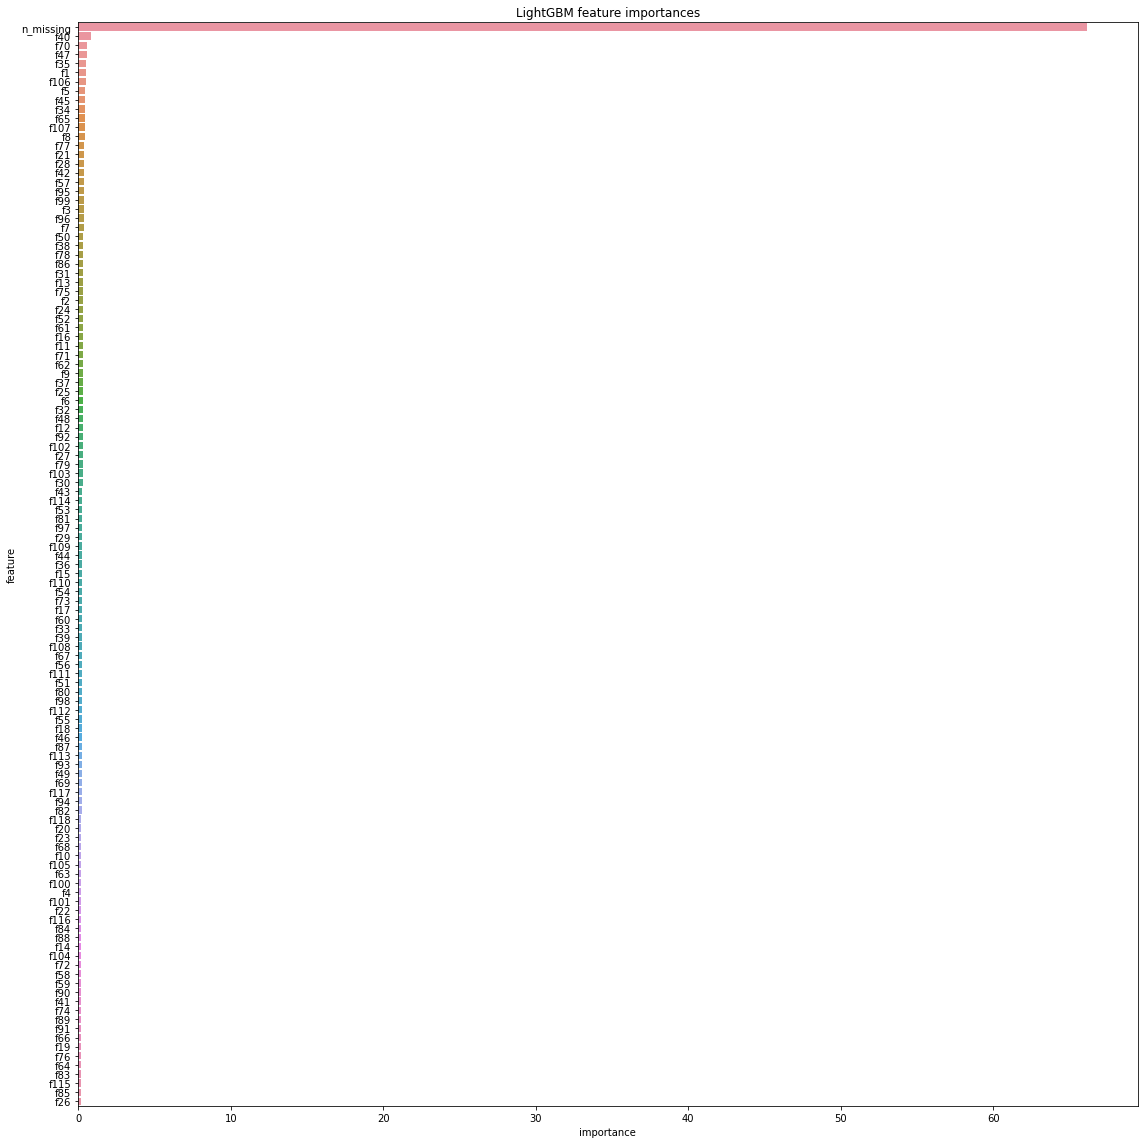

In [14]:
order = list(ctb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=ctb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("LightGBM feature importances")

# Submission

In [15]:
submission[target] = ctb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,claim
0,957919,0.586780
1,957920,0.119357
2,957921,0.623253
3,957922,0.127988
4,957923,0.141587
...,...,...
493469,1451388,0.824959
493470,1451389,0.117572
493471,1451390,0.754963
493472,1451391,0.127904


# Log

seeds
2017-2018 ver2
2019 ver5
2020 ver6
2021 ver7
2022 ver8
2023 ver9
2024 ver10
2025 ver11
2026 ver12